In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
#os.chdir("/content/drive/MyDrive/共有フォルダ/実験")
os.chdir("/content/drive/MyDrive/松尾研究所/世界モデルと知能/最終課題/共有フォルダ/実験/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# 加工する関数
def process_image(imgs, k=None):

    batch_size = imgs.size(0)

    img = transforms.ToPILImage()(imgs[0])

    filter = np.zeros((batch_size, img.size[1], img.size[0], 3))
    for i in range(batch_size):
        n = random.randint(0, 2) if k == None else k
        filter[i, :, :, n] = 1.0

    filter_tensor = torch.from_numpy(filter.astype('float32')).permute(0, 3, 1, 2)

    ratio = 0.8
    imgs = imgs * ratio + filter_tensor * (1 - ratio)

    return imgs

def show_imgs(imgs, labels=None):
    num_images = len(imgs)

    normal_imgs = imgs
    transformed_imgs = process_image(imgs)

    fig = plt.figure(figsize=(16, 6))
    for i in range(num_images):

        ax = fig.add_subplot(2, num_images, i+1)
        ax.imshow(normal_imgs[i].permute(1, 2, 0))
        if labels is not None:
            ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデル（別の構成）
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 15, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(15),

            nn.Conv2d(15, 18, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(18, 12, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Conv2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Flatten(),

            nn.Linear(12*7*7, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, z_dim * 2),
            nn.BatchNorm1d(z_dim * 2),
            nn.ReLU(),
        )

        self.enc_mean = nn.Linear(z_dim * 2, z_dim)
        self.enc_std = nn.Linear(z_dim * 2, z_dim)

        # Decoder
        self.dec_lin = nn.Linear(z_dim, z_dim * 2)
        self.dec = nn.Sequential(
            nn.Linear(z_dim*2, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, 12*7*7),
            nn.BatchNorm1d(12*7*7),
            nn.ReLU(),

            nn.Unflatten(1, (12, 7, 7)),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.ConvTranspose2d(12, 18, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(18, 18, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.ConvTranspose2d(18, 15, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(15, 3, kernel_size=1, stride=1, padding=0),

            nn.Sigmoid()
        )

    def encoder(self, x):
        h = self.enc(x)
        mean = self.enc_mean(h)
        std = F.softplus(self.enc_std(h))

        return mean, std

    def decoder(self, z):
        h = self.dec_lin(z)
        x = self.dec(h)
        return x

    def sample_z(self, mean: torch.Tensor, std: torch.Tensor):
        if self.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def loss(self, x: torch.Tensor):
        mean, std = self.encoder(x)

        z = self.sample_z(mean, std)
        y = self.decoder(z)

        x_flat = x.view(x.size(0), -1)
        y_flat = y.view(y.size(0), -1)
        KL_loss = nn.KLDivLoss(reduction='batchmean')(mean, std)
        reconstruction_loss = nn.MSELoss()(x_flat, y_flat)

        return -KL_loss, reconstruction_loss, y, z

In [ ]:
import json
with open('./data-mean.json') as f:
    data = json.load(f)

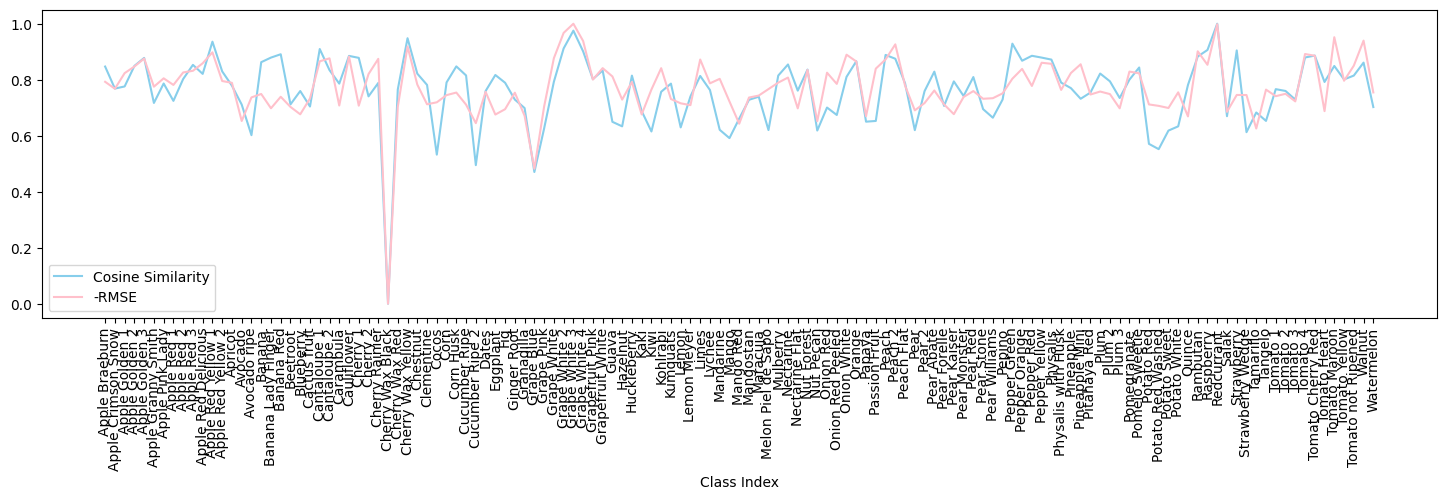

In [53]:
from sklearn.preprocessing import minmax_scale

# 各ラベルごとに潜在変数の距離を可視化
# コサイン類似度とRMSEの評価指標にて距離を計算
# RMSEは距離が小さい方が上になるように、y軸を反転

rmse_scores = {}
cosine_similarities = {}
labels = []

for label in data:
    class_data = data[label]
    normal_z = torch.tensor(class_data["normal"])
    processed_z = torch.tensor(class_data["processed"])

    diff = normal_z - processed_z
    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    rmse_scores[label] = -rmse.item()

    similarity = F.cosine_similarity(normal_z, processed_z)
    cosine_similarities[label] = similarity.mean()

    labels.append(label)

fig, ax = plt.subplots(figsize=(18, 4))

v1 = minmax_scale(list(cosine_similarities.values()))
v2 = minmax_scale(list(rmse_scores.values()))

ax.plot(labels, v1, color="skyblue", label="Cosine Similarity")
ax.plot(labels, v2, color="pink", label="-RMSE")

ax.set_xlabel("Class Index")
ax.set_xticklabels(labels, rotation=90)

ax.legend()

plt.show()

In [ ]:
from sklearn.preprocessing import minmax_scale

# 各ラベルごとに潜在変数の距離を可視化
# コサイン類似度とRMSEの評価指標にて距離を計算
# RMSEは距離が小さい方が上になるように、y軸を反転

rmse_scores = {}
cosine_similarities = {}
labels = []

for label in data:
    class_data = data[label]
    normal_z = torch.tensor(class_data["normal"])
    processed_z = torch.tensor(class_data["processed"])

    diff = normal_z - processed_z
    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    rmse_scores[label] = -rmse.item()

    similarity = F.cosine_similarity(normal_z, processed_z)
    cosine_similarities[label] = similarity.mean()

    labels.append(label)

fig, ax = plt.subplots(figsize=(18, 4))

v1 = minmax_scale(list(cosine_similarities.values()))
v2 = minmax_scale(list(rmse_scores.values()))

ax.plot(labels, v1, color="skyblue", label="Cosine Similarity")
ax.plot(labels, v2, color="pink", label="-RMSE")

ax.set_xlabel("Class Index")
ax.set_xticklabels(labels, rotation=90)

ax.legend()

plt.show()

In [54]:
"""別表示の場合
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8))

ax1.plot(labels, cosine_similarities.values())
ax1.set_xlabel("Class Index")
ax1.set_xticklabels(labels, rotation=90)
ax1.set_ylabel("Cosine Similarity")

ax2.plot(labels, rmse_scores.values())
ax2.set_xlabel("Class Index")
ax2.set_xticklabels(labels, rotation=90)
ax2.set_ylabel("RMSE")
ax2.invert_yaxis()

fig.tight_layout()

plt.show()"""

'別表示の場合\nfig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8))\n\nax1.plot(labels, cosine_similarities.values())\nax1.set_xlabel("Class Index")\nax1.set_xticklabels(labels, rotation=90)\nax1.set_ylabel("Cosine Similarity")\n\nax2.plot(labels, rmse_scores.values())\nax2.set_xlabel("Class Index")\nax2.set_xticklabels(labels, rotation=90)\nax2.set_ylabel("RMSE")\nax2.invert_yaxis()\n\nfig.tight_layout()\n\nplt.show()'

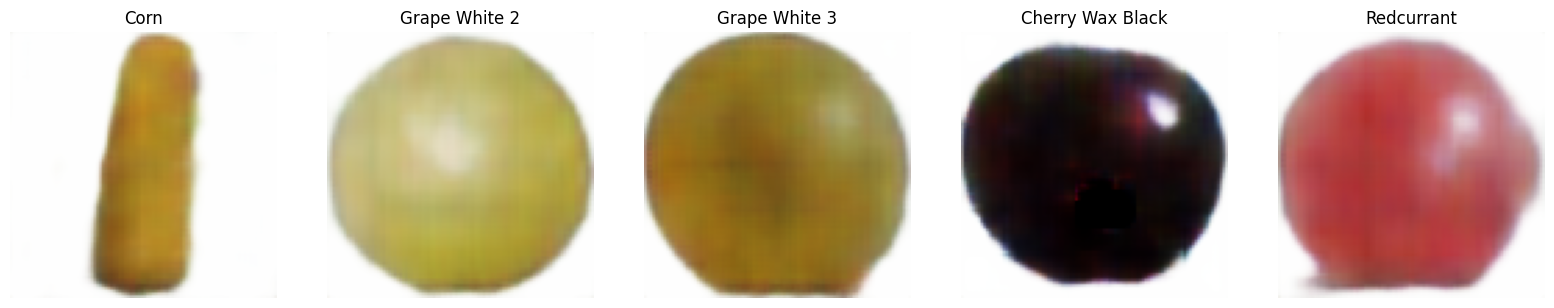

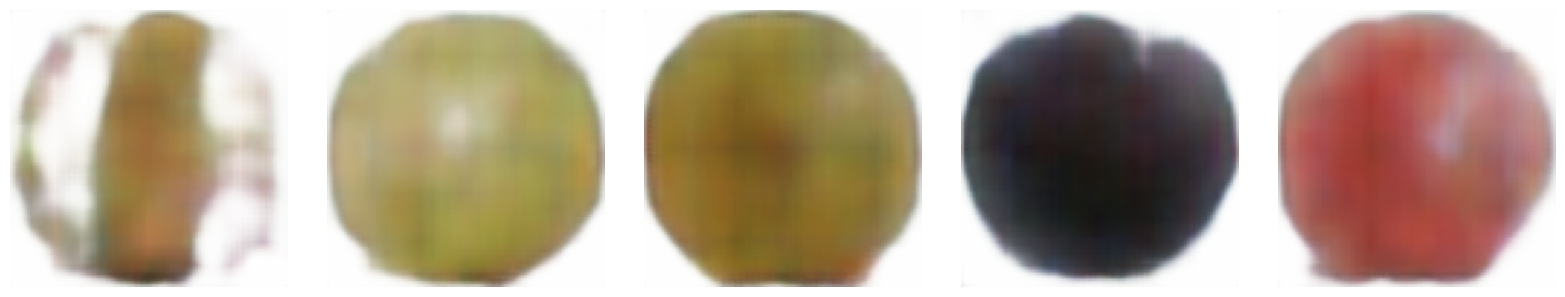

In [36]:
# 1. 類似度から気になる果物を実際に描画して、その原因を考えてみる
# 同じ果物の複数枚で検証することがおすすめ

model = VAE(z_dim=36).to(device)
model.load_state_dict(torch.load('./model.pth'))
labels = ["Corn", "Grape White 2", "Grape White 3", "Cherry Wax Black", "Redcurrant"]

normals, processeds = [], []
model.eval()
with torch.no_grad():
    for target_label in labels:
        class_data = data[target_label]

        normal_z = torch.tensor(class_data["normal"][:3]).to(device)
        processed_z = torch.tensor(class_data["processed"][:3]).to(device)

        # 通常画像の再構成
        normal_reconstructed = model.decoder(normal_z)
        normal_reconstructed = normal_reconstructed.cpu().detach()
        normals.append(normal_reconstructed[1])

        # 加工画像の再構成
        processed_reconstructed = model.decoder(processed_z)
        processed_reconstructed = processed_reconstructed.cpu().detach()
        processeds.append(processed_reconstructed[1])

show_imgs(torch.stack(normals), labels)
show_imgs(torch.stack(processeds))

In [ ]:
# 2. 2次元グラフで可視化すると面白いかも？ ヒートマップ
#z = torch.rand(10, 36)
#z = z.view(10, 6, 6)

# ラベルがリンゴの潜在表現[z1, z2, z3, z4 ...]の成分ごとに相関係数をヒートマップで表示
# 値が大きく示された成分 → リンゴであることを示す部分

""" 保留
target_label = "Potato Red Washed"

for label in data:
    if label == target_label:
      for k in range(len(normal['z'])):
        n = random.randint(0, len(normal['z'][0]) - 1)
        zs = np.array([normal['z'][n] for _ in range(SIZE)])
        vs = np.linspace(-2, 2, len(zs))
        for i in range(len(zs)):
          zs[i][k] = vs[i]
        zs = torch.from_numpy(zs).float().to(device)



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr = pd.pivot_table(data=df_flights, values='passengers',
                                  columns='year', index='month', aggfunc=np.mean)
sns.heatmap(corr)
"""

In [ ]:
data.keys()

dict_keys(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracu

In [ ]:
# 3. 有意差の検証（果物全体で分散・平均とか基本的な統計量を調べて、評価する）できれば、表にする
import pandas as pd
import torch

labels = data.keys()
cos = []

for label in data:
        class_data = data[label]
        normal_z = torch.tensor(class_data["normal"])
        processed_z = torch.tensor(class_data["processed"])

# 平均・分散
normal_z_mean = torch.mean(normal_z)
processed_z_mean = torch.mean(processed_z)

normal_z_var = torch.var(normal_z)
processed_z_var = torch.var(processed_z)



# 表の作成
table = [['データ', '平均', '分散'],
         ['normal_z', normal_z_mean, normal_z_var],
         ['processed_z', processed_z_mean, processed_z_var]]
df = pd.DataFrame(table)
df

"\n# 表の作成\ntable = [['データ', '平均', '分散'],\n         ['normal_z', normal_z_mean, normal_z_var],\n         ['processed_z', processed_z_mean, processed_z_var]]\ndf = pd.DataFrame(table)\ndf"

In [ ]:
# 変えたやつ
# 3. 有意差の検証（果物全体で分散・平均とか基本的な統計量を調べて、評価する）できれば、表にする
import pandas as pd
import torch

labels = data.keys()
cos = []

# 潜在変数の平均と分散をそれぞれ保存する
means = {"normal": [], "processed": []}
vars = {"normal": [], "processed": []}

for label in data:
    class_data = data[label]
    normal_z = torch.tensor(class_data["normal"])
    processed_z = torch.tensor(class_data["processed"])

    # 平均・分散
    means["normal"].append(torch.mean(normal_z))
    means["processed"].append(torch.mean(processed_z))

    vars["normal"].append(torch.var(normal_z))
    vars["processed"].append(torch.var(processed_z))

In [ ]:
# 4. 他の誤差関数についてもグラフ化してみる（MAEとか…）